# Recommendations System - IBM Watson Studio

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [SVD Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline
sns.set(color_codes=True)

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df['article_id'] = df['article_id'].astype(str)
df.dtypes

article_id    object
title         object
email         object
dtype: object

In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` Distribution of how many articles a user interacts with in the dataset.

In [4]:
df_count = df.groupby('email').count().iloc[:,:1]
df_count.columns = ['interactions']
df_count.describe()

,interactions
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


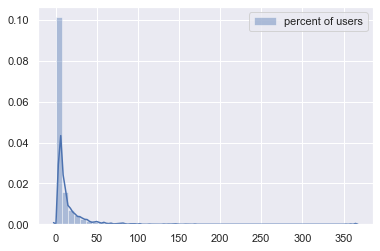

In [5]:
sns.distplot(df_count, label="percent of users")
plt.legend();

In [6]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
df_content.shape

(1056, 5)

In [8]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset = 'article_id')]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [9]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset = 'article_id', inplace = True)

In [10]:
df_content.shape

(1051, 5)

`3.` 

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

In [12]:
len(df[~df['email'].isnull()]['article_id'].unique())

714

In [13]:
len(df_content['article_id'].unique())

1051

In [14]:
len(df[~df.isnull()]['article_id'])

45993

In [15]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` The most viewed **article_id**, as well as how often it was viewed.  `email_mapper` function to map users to ids.  There were a small number of null values, and all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
df.groupby(['article_id', 'title']).count().sort_values('email', ascending = False).head()

,,email
article_id,title,
1429.0,use deep learning for image classification,937
1330.0,insights from new york car accident reports,927
1431.0,visualize car data with brunel,671
1427.0,"use xgboost, scikit-learn & ibm watson machine learning apis",643
1364.0,predicting churn with the spss random tree algorithm,627


In [17]:
df.groupby(['article_id', 'title']).count().sort_values('email', ascending = False).index[0][0]

'1429.0'

In [18]:
df.groupby(['article_id', 'title']).count().sort_values('email', ascending = False).index[0][1]

'use deep learning for image classification'

In [19]:
df.groupby(['article_id', 'title']).count().sort_values('email', ascending = False).iloc[0,:][0]

937

In [20]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [21]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Return the **n** top articles ordered with most interactions as the top.

In [22]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(['article_id', 'title']).count().sort_values('user_id', ascending = False).reset_index().head(n)['title'])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df.groupby(['article_id', 'title']).count().sort_values('user_id', ascending = False).reset_index().head(n)['article_id'])
 
    return top_articles # Return the top article ids

In [23]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [24]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df = df.drop_duplicates()
    user_item = df.groupby(['user_id', 'article_id']).count().iloc[:,0].unstack()
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

`2.` Take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [25]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    items1_m = np.ma.array(user_item.loc[user_id], mask=np.isnan(user_item.loc[user_id]))
    items2_m = np.ma.array(user_item.transpose(), mask=np.isnan(user_item.transpose()))
    sim_mat = np.ma.dot(items1_m, items2_m).data
    
    # sort by similarity
    sim_df = pd.DataFrame(sim_mat, columns = ['similarity'])
    sim_df.index = np.arange(1, len(sim_df)+1)
    sim_df.sort_values('similarity', ascending = False, inplace = True)

    # create list of just the ids
    # remove the own user's id
    most_similar_users = sim_df.index.values[sim_df.index.values != user_id]
    
    return list(most_similar_users) # return a list of the users in order from most to least similar
        

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find and return articles you can recommend to each user.

In [26]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = list(df[df['article_id'].isin(article_ids)]['title'].unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = list(user_item.loc[user_id][user_item.loc[user_id] > 0].index.values)
    article_names = get_article_names(article_ids)

    return (article_ids, article_names) # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    articles_seen_id = get_user_articles(user_id)[0]
    sim_users = find_similar_users(user_id)
    
    recs_lst = np.array([])
    
    for user in sim_users:
        articles_id = get_user_articles(user)[0]
        new_rec = np.setdiff1d(articles_id, articles_seen_id, assume_unique = True)
        recs_lst = np.unique(np.concatenate([new_rec, recs_lst], axis = 0))
        
        if len(recs_lst) > m-1:
            break
    
    return recs_lst[:m] # return your recommendations for this user_id  

In [27]:
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10)) 

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

`4.` Improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [28]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    sim_users = find_similar_users(user_id)
    similarity = []
    n_interact = []

    for user in sim_users:
        items1_m = np.ma.array(user_item.loc[user_id], mask=np.isnan(user_item.loc[user_id]))
        items2_m = np.ma.array(user_item.loc[user].transpose(), mask=np.isnan(user_item.loc[user].transpose()))
        sim = np.ma.dot(items1_m, items2_m).data
        n_int = user_item.loc[user][~user_item.loc[user].isnull()].count()
        similarity.append(sim)
        n_interact.append(n_int)
    
    neighbors_df = pd.DataFrame({
        'users': sim_users, 
        'similarity': similarity, 
        'num_interact': n_interact
    }, columns = ['users', 'similarity', 'num_interact'])
    
    neighbors_df['similarity'] = neighbors_df['similarity'].astype(float)
    
    neighbors_df.sort_values(['similarity', 'num_interact'], ascending = False, inplace = True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    top_sorted_users = get_top_sorted_users(user_id, df=df, user_item=user_item)
    
    articles_seen_id = get_user_articles(user_id)[0]
    recs_lst = np.array([])
        
    for user in top_sorted_users['users']:
        articles_id = get_user_articles(user)[0]
        new_rec = np.setdiff1d(articles_id, articles_seen_id, assume_unique = True)
        recs_lst = np.unique(np.concatenate([new_rec, recs_lst], axis = 0))

        if len(recs_lst) > m-1:
            break
    
    recs = recs_lst[:m]
    rec_names = get_article_names(recs_lst[:m])
    
    return recs, rec_names

In [29]:
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1014.0' '1059.0' '109.0' '111.0' '1157.0' '1162.0' '1164.0' '1172.0'
 '1186.0' '12.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'analyze energy consumption in buildings', 'analyze open data sets with pandas dataframes', 'apache spark lab, part 3: machine learning', 'airbnb data for analytics: washington d.c. listings', 'airbnb data for analytics: amsterdam calendar', 'tidy up your jupyter notebooks with scripts', 'tensorflow quick tips', '1448    i ranked every intro to data science course on...\nName: title, dtype: object', 'connect to db2 warehouse on cloud and db2 using scala']


`5.` If we were given a new user, we should use Rank Based Recommendations for new users or Content Based Recommendations. This is the Cold Start Problem with new users.

In [30]:
# Use Rank Based Recommendations to give top 10 recommended articles for a new user.
get_top_articles(10)

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm',
 'healthcare python streaming application demo',
 'finding optimal locations of new store using decision optimization',
 'apache spark lab, part 1: basic concepts',
 'analyze energy consumption in buildings',
 'gosales transactions for logistic regression model']

### <a class="anchor" id="Matrix-Fact">Part IV: SVD Matrix Factorization</a>

`1.` Use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [35]:
# Load the matrix
user_item_matrix = user_item.replace(np.nan, 0.0)

In [36]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.

In [37]:
# SVD on the User-Item Matrix
u, s, vt = np.linalg.svd(user_item_matrix)

Missing values in the user-item matrix are imputed with 0.0's into a sparse matrix. Since there are no missing values, the user-item matrix can be decomposed using Singular Value Decomposition. As in the lessons, we could instead impute random values for each cell in the matrix and optimize all the cells iteratively by minimizing error using a gradient descent algorithm over many epochs.

In [38]:
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

`3.` Now for the tricky part, how do we choose the number of latent features to use?  From below, as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Accuracy improves as we increase the number of latent features.

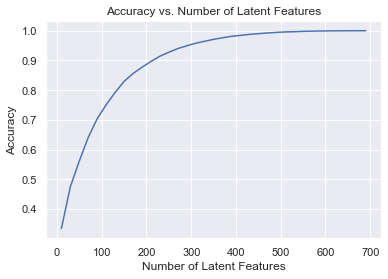

In [39]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data.  Accuracy of the training and test sets of data varies with different numbers of latent features.

In particular, we first find out the following:

* How many users can we make predictions for in the test set? 20
* How many users are we not able to make predictions for because of the cold start problem? 662
* How many articles can we make predictions for in the test set? 574
* How many articles are we not able to make predictions for because of the cold start problem? 0

In [40]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train).replace(np.nan, 0.0)
    user_item_test = create_user_item_matrix(df_test).replace(np.nan, 0.0)
    test_idx = df_test['user_id']
    test_arts = df_test['article_id']
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [41]:
np.intersect1d(test_idx, user_item_train.index.values).shape

(20,)

In [42]:
np.intersect1d(test_arts, user_item_train.columns).shape

(574,)

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining `2` - `4`.

How well does SVD work towards making predictions for recommendations on the test data?

In [43]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [44]:
u_train_int = u_train[np.where(np.intersect1d(user_item_train.index.values, user_item_test.index.values))]
u_train_int.shape

(20, 4487)

In [45]:
v_train = vt_train.transpose()
vt_train_int = v_train[np.where(np.intersect1d(user_item_train.columns, user_item_test.columns))].transpose()
vt_train_int.shape

(714, 574)

In [46]:
user_test_int = np.array(user_item_test)[np.where(np.intersect1d(user_item_test.index.values, user_item_train.index.values))]
user_test_int.shape

(20, 574)

In [47]:
# How well can the training decomposition be used to predict on test data
n = 100
total_var = np.sum(s_train**2)
var_exp = np.sum(s_train[:n] ** 2)
perc_exp = round(var_exp/total_var*100, 2)
print("Total variability: {:.2f} \nVariability from first two principal components: {:.2f} \nPercentage explained by first {} components {:.2f}%"\
      .format(total_var, var_exp, n, perc_exp))

Total variability: 29264.00 
Variability from first two principal components: 18834.24 
Percentage explained by first 100 components 64.36%


In [48]:
pred_ratings = np.dot(np.dot(u_train_int[:,:n], np.diag(s_train[:n])), vt_train_int[:n,:])
sum_square_errs = np.sum(np.sum((user_test_int - pred_ratings)**2))
sum_square_errs

431.3189370669836

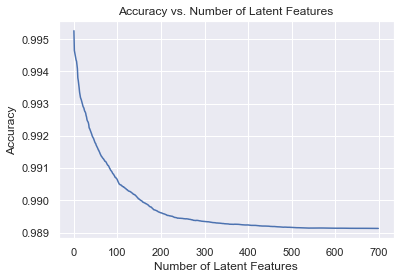

In [49]:
num_latent_feats = 700
sum_square_errs = []
for k in range(num_latent_feats):
    pred_ratings = np.dot(np.dot(u_train_int[:,:k], np.diag(s_train[:k])), vt_train_int[:k,:])
    error = np.sum(np.sum((user_test_int - pred_ratings)**2))
    sum_square_errs.append(error)
        
plt.plot(range(num_latent_feats), 1 - np.array(sum_square_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` How to improve on recommendations of articles? 

A higher number of latent features led to a lower out of sample accuracy. This suggests that the recommendations system using SVD given the current training dataset does not generalize well into the testing dataset. To improve on these results, a recommendation system using FunkSVD may be used, or some form of content based recommendation system.